In [1]:
import os
import glob
from collections import defaultdict
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, GPTNeoXForCausalLM

In [2]:
model_names = [
    "pythia-70m",
    "pythia-160m",
    "pythia-410m",
    "pythia-1b",
    "pythia-1.4b",
    "pythia-2.8b",
    "pythia-6.9b",
    "pythia-12b",
]

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
cache_dir = "/om/user/ericjm/visualizing-neural-scaling/cache/"
step = 143000
model_name = model_names[0]

tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
)

In [5]:
def alternates(word):
    mutations = [
        word,
        word.capitalize(),
        word.upper(),
        " " + word,
        " " + word.capitalize(),
        " " + word.upper(),
        # remove spaces
        word.replace(" ", ""),
        word.replace(" ", "").capitalize(),
        word.replace(" ", "").upper(),
        " " + word.replace(" ", ""),
        " " + word.replace(" ", "").capitalize(),
        " " + word.replace(" ", "").upper(),
    ]
    return list(set(mutations))

def alternate_tokens(word, tokenizer):
    return {
        tokenizer.encode(mutation, add_special_tokens=False)[0]: mutation
        for mutation in alternates(word) 
        if len(tokenizer.encode(mutation, add_special_tokens=False)) == 1
    }

def get_closest_tokens_euclidean(embedding, embeddings, tokenizer, topk=10):
    # Calculate distances.
    distances = torch.norm(embeddings - embedding, dim=1)
    # Get the top k smallest distances.
    sims, indices = torch.topk(distances, topk, largest=False)
    
    # Decode the token IDs to tokens.
    closest_tokens = [tokenizer.decode([token_id]) for token_id in indices]
    return {
        sims[i].item(): closest_tokens[i]
        for i in range(len(closest_tokens))
    }

def get_closest_tokens_cosine(embedding, embeddings, tokenizer, topk=10):
    # Calculate similarities. We use cosine similarity here.
    similarities = F.cosine_similarity(embedding.unsqueeze(0), embeddings)
    # Get the top k indices.
    sims, indices = torch.topk(similarities, topk)
    
    # Decode the token IDs to tokens.
    closest_tokens = [tokenizer.decode([token_id]) for token_id in indices]
    return {
        sims[i].item(): closest_tokens[i]
        for i in range(len(closest_tokens))
    }

### find pairs of uncapitalized and capitalized tokens

In [6]:
token_and_capitalized = []
for i in tqdm(range(tokenizer.vocab_size)):
    token = tokenizer.decode([i])
    if token[0] == " ":
        alts = alternate_tokens(token, tokenizer)
        for token_id, alternate in alts.items():
            if (token.upper() != token) and (token[1:].capitalize() != token[1:]) and (token[1:].capitalize() == alternate[1:]):
                token_and_capitalized.append((i, token_id))

  0%|          | 0/50254 [00:00<?, ?it/s]

In [7]:
len(token_and_capitalized)

4491

In [8]:
for lowercase_id, uppercase_id in token_and_capitalized[2000:2010]:
    print(tokenizer.decode([lowercase_id]), tokenizer.decode([uppercase_id]))

 creating  Creating
 anc  Anc
 employees  Employees
 arms  Arms
 download  Download
 supply  Supply
 mes  Mes
 train  Train
 lit  Lit
 diet  Diet


In [9]:
cache_dir = "/om/user/ericjm/visualizing-neural-scaling/cache/"
step = 143000
model_name = model_names[0]
tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
)
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
).to(device)
embed = model.gpt_neox.embed_in.weight.data.detach().cpu().numpy()
unembed = model.embed_out.weight.data.detach().cpu().numpy()

# load up the initial model embeddings (step 0)
step = 0
tokenizer = AutoTokenizer.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
)
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/{model_name}",
    revision=f"step{step}",
    cache_dir=os.path.join(cache_dir, model_name, f"step{step}"),
).to(device)
embed_initial = model.gpt_neox.embed_in.weight.data.detach().cpu().numpy()
unembed_initial = model.embed_out.weight.data.detach().cpu().numpy()

In [10]:
# Create dataset
embeddings = []
labels = []

for lowercase_id, uppercase_id in token_and_capitalized:
    embeddings.append(embed[lowercase_id])
    labels.append(0)  # 0 for lowercase
    embeddings.append(embed[uppercase_id])
    labels.append(1)  # 1 for uppercase

# Convert list to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

In [11]:
# Create a train and test split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

In [12]:
# Initialize and fit the logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [13]:
# Now clf can be used to predict whether an embedding is a capitalized or uncapitalized token
# Let's test it on the test set
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# Measure the performance
accuracy = np.mean(y_pred == y_test)
accuracy_train = np.mean(y_pred_train == y_train)
print(f'Test accuracy: {accuracy*100:.2f}%')
print(f'Train accuracy: {accuracy_train*100:.2f}%')

Test accuracy: 99.89%
Train accuracy: 99.90%


In [14]:
# project embeddings onto vector orthogonal to the decision boundary
# Get the normal vector to the decision boundary
normal_vector = clf.coef_[0]

# Get the bias term
bias = clf.intercept_

# Project both training and test data onto this vector
projection_train = np.dot(X_train, normal_vector)
projection_test = np.dot(X_test, normal_vector)

# Separate the projections based on the labels
lowercase_train = projection_train[y_train == 0]
uppercase_train = projection_train[y_train == 1]
lowercase_test = projection_test[y_test == 0]
uppercase_test = projection_test[y_test == 1]

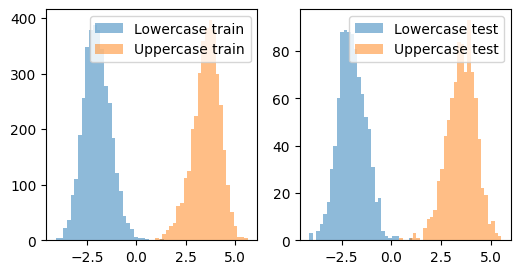

In [15]:
# Plot histograms
plt.figure(figsize=(6, 3)) # width, height
plt.subplot(1, 2, 1)
plt.hist(lowercase_train, bins=30, alpha=0.5, label='Lowercase train')
plt.hist(uppercase_train, bins=30, alpha=0.5, label='Uppercase train')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(lowercase_test, bins=30, alpha=0.5, label='Lowercase test')
plt.hist(uppercase_test, bins=30, alpha=0.5, label='Uppercase test')
plt.legend(loc='upper right')
# plt.title('Projection of embeddings onto decision boundary normal')
# plt.xlabel('Projection')
# plt.ylabel('Count')
# plt.show()

In [16]:
# want to compute the accuracy on the initial embeddings now
embeddings_initial = []
labels_initial = []

for lowercase_id, uppercase_id in token_and_capitalized:
    embeddings_initial.append(embed_initial[lowercase_id])
    labels_initial.append(0)  # 0 for lowercase
    embeddings_initial.append(embed_initial[uppercase_id])
    labels_initial.append(1)  # 1 for uppercase

# Convert list to numpy arrays
embeddings_initial = np.array(embeddings)
labels_initial = np.array(labels)

In [17]:
y_pred = clf.predict(embeddings_initial)

# Measure the performance
accuracy = np.mean(y_pred == labels_initial)
print(f'Accuracy on initial embeddings: {accuracy*100:.2f}%')

Accuracy on initial embeddings: 99.90%


In [18]:
# Project embeddings_initial onto vector orthogonal to the decision boundary
projection_initial = np.dot(embeddings_initial, normal_vector)

# Separate the projections based on the labels
lowercase_initial = projection_initial[labels_initial == 0]
uppercase_initial = projection_initial[labels_initial == 1]

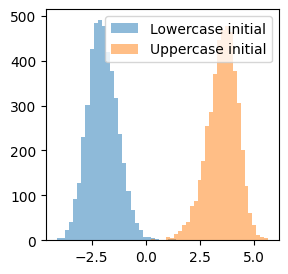

In [21]:
# Plot histograms
plt.figure(figsize=(3, 3)) # width, height
plt.hist(lowercase_initial, bins=30, alpha=0.5, label='Lowercase initial')
plt.hist(uppercase_initial, bins=30, alpha=0.5, label='Uppercase initial')
plt.legend(loc='upper right')

In [24]:
# generate some random data to first fit the logistic regression to
X = np.random.randn(10, embeddings_initial.shape[1])
y = np.random.randint(2, size=10)

In [27]:
# let's compute the accuracy for a bunch of random decision boundaries
accuracies = []
for _ in tqdm(range(30000)):
    coef = np.random.normal(size=embed.shape[1])
    intercept = np.random.normal()
    clf = LogisticRegression(random_state=0).fit(X, y)
    clf.coef_ = np.array([coef])
    clf.intercept_ = np.array([intercept])
    y_pred = clf.predict(embeddings_initial)
    accuracy = np.mean(y_pred == labels_initial)
    accuracies.append(accuracy)

  0%|          | 0/30000 [00:00<?, ?it/s]

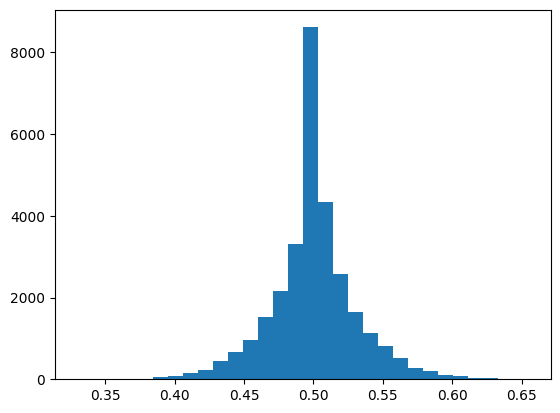

In [28]:
_ = plt.hist(accuracies, bins=30)

In [29]:
np.std(accuracies)

0.03107110987772748